# Introduction



This is an implementation of semantic segmentation transfer learning.
<br><br>
The model to be implemented here is based on the model developed in the paper "*The devil is in the labels: Semantic segmentation from sentences*".
<br>
The authors claim that their method, while operating in zero-shot setting, achieves results comparable to those of supervised learning; and it was possible by replacing the class labels with embeddings generated from sentences. Furthermore, fine-tuning the model to a given semantic segmentation dataset, should further improve the performance of the model.
<br>
The target is to adapt the original model to a new dataset; in this case, the *CMP Facade Database*
<br><br>
**Development Steps:**
*   Copy required functions from the original paper code to this Google Colab document (and update as required)
*   Create an iterator for the new dataset to suit the implementation
*   Allow the model to freeze the encoder while updating gradients for the head
*   Give meaningful explanation to the *CMP Facade Database* labels and use them to build embeddings. The explanations are obtained from [*merriam-webster*](https://www.merriam-webster.com/) while the embeddings are build with the  CLIP-ViT model (Same as the paper)
*    Integrate [*Weights & Biases*](https://wandb.ai/) to track experiment results. This step is done to show the relation between hyper-parameters and model performance
*    Fine-tune the model using the *CMP Facade Database*
*    Evaluate the performance of the model using the Mean IoU metric
<br>

**Notes:**
*    The *CMP Facade Database* consists of two datasets, base ane extended. The base dataset is used for training while the extended extended dataset is used for testing
*    The GPU memory may sometimes be filled, that is why garbage collection is called on multiple points in the code

**Links:**
*    ["The devil is in the labels: Semantic segmentation from sentences" Paper](https://arxiv.org/abs/2202.02002)
*    [Original Code Github Repository](https://github.com/irfanICMLL/SSIW/tree/master)
*    [CMP Facade Database](https://cmp.felk.cvut.cz/~tylecr1/facade/)
*    A link is provided in the Results section below for the results report

# Implementation

Parameters that can be tweaked in the implementation:


```
USE_WANDB        #bool                 | whether to use W&B or not
MAX_MEMORY       #int                  | max image memory (used to avoid OutOfMemoryError)
DEFINITIONS_TYPE #"word" or "sentence" | label definition types
MODEL_NAME       #str                  | name used to save the fine-tuned model
OPTIMIZER_NAME   #"adam" or "sgd"      | optimizer to use
LR               #float                | learning rate
EPOCHS           #int                  | number of training epochs
```



In [ ]:
#install packages required for original paper code
!pip install -U openmim  
!mim install mmcv-full 
!pip install mmsegmentation
!pip install timm
!pip install tqdm
!pip install wandb
!pip install git+https://github.com/openai/CLIP.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.2 MB/s 
     |████████████████████████████████| 237 kB 61.7 MB/s 
     |████████████████████████████████| 51 kB 8.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.0/index.html
     |████████████████████████████████| 46.1 MB 375 kB/s 
     |████████████████████████████████| 190 kB 37.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 828 kB 35.6 MB/s 
     |████████████████████████████████| 648 kB 70.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 35.9 MB/s 
     |████████████████████████████████| 182 kB 76.9 MB/s

In [ ]:
#import libraries
import clip
import cv2
import gc
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
import torch
import torch.distributed as dist
import torch.nn as nn
import torch.nn.functional as F
import wandb

from abc import ABCMeta
from functools import partial
from mmcv.cnn import ConvModule
from mmcv.cnn.bricks import build_norm_layer
from mmcv.runner import load_checkpoint
from mmseg.ops import resize
from mmseg.utils import get_root_logger
from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
from torchvision.transforms.functional import resize as im_resize
from tqdm import tqdm
from typing import Optional, Tuple
from zipfile import ZipFile

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [ ]:
#login to weights and biases
#weights and biases service is used to track experiment results
USE_WANDB = False

if USE_WANDB: wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
#set project directories
ROOT_PATH = '/content/data/'
DATASETS_DIR = 'datasets'
EMBEDDINGS_DIR = 'embeddings'
MODELS_DIR = 'models'
BASE_MODEL_DIR = os.path.join(MODELS_DIR, 'base')
PREDICTIONS_DIR = 'predictions'

#create required directories
os.makedirs(os.path.join(ROOT_PATH, DATASETS_DIR), exist_ok = True)
os.makedirs(os.path.join(ROOT_PATH, EMBEDDINGS_DIR), exist_ok = True)
os.makedirs(os.path.join(ROOT_PATH, BASE_MODEL_DIR), exist_ok = True) #will also create models dir
os.makedirs(os.path.join(ROOT_PATH, PREDICTIONS_DIR), exist_ok = True)

In [ ]:
#prepare processing device
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.set_device(0)

dist_url = 'tcp://127.0.0.1:6769'
dist_url = dist_url[:-2] + str(os.getpid() % 100).zfill(2)
dist.init_process_group(backend = "nccl", init_method = dist_url, world_size = 1, rank = 0,)

In [ ]:
#copy required classes and functions from the original paper code

#######################################################################################################################################
#decode_head.py

#from ..builder import build_loss
#from ..losses import accuracy
#from mmcv.cnn import normal_init
#from mmcv.runner import auto_fp16, force_fp32
#from mmseg.core import build_pixel_sampler
#from mmseg.ops import resize


class BaseDecodeHead(nn.Module, metaclass=ABCMeta):
    """Base class for BaseDecodeHead.
    Args:
        in_channels (int|Sequence[int]): Input channels.
        channels (int): Channels after modules, before conv_seg.
        num_classes (int): Number of classes.
        dropout_ratio (float): Ratio of dropout layer. Default: 0.1.
        conv_cfg (dict|None): Config of conv layers. Default: None.
        norm_cfg (dict|None): Config of norm layers. Default: None.
        act_cfg (dict): Config of activation layers.
            Default: dict(type='ReLU')
        in_index (int|Sequence[int]): Input feature index. Default: -1
        input_transform (str|None): Transformation type of input features.
            Options: 'resize_concat', 'multiple_select', None.
            'resize_concat': Multiple feature maps will be resize to the
                same size as first one and than concat together.
                Usually used in FCN head of HRNet.
            'multiple_select': Multiple feature maps will be bundle into
                a list and passed into decode head.
            None: Only one select feature map is allowed.
            Default: None.
        loss_decode (dict): Config of decode loss.
            Default: dict(type='CrossEntropyLoss').
        ignore_index (int | None): The label index to be ignored. When using
            masked BCE loss, ignore_index should be set to None. Default: 255
        sampler (dict|None): The config of segmentation map sampler.
            Default: None.
        align_corners (bool): align_corners argument of F.interpolate.
            Default: False.
    """

    def __init__(self,
                 in_channels,
                 channels,
                 *,
                 num_classes,
                 dropout_ratio=0.1,
                 conv_cfg=None,
                 norm_cfg=None,
                 act_cfg=dict(type='ReLU'),
                 in_index=-1,
                 input_transform=None,
                 loss_decode=dict(
                     type='CrossEntropyLoss',
                     use_sigmoid=False,
                     loss_weight=1.0),
                 ignore_index=255,
                 sampler=None,
                 align_corners=False):
        super(BaseDecodeHead, self).__init__()
        self._init_inputs(in_channels, in_index, input_transform)
        self.channels = channels
        self.num_classes = num_classes
        self.dropout_ratio = dropout_ratio
        self.conv_cfg = conv_cfg
        self.norm_cfg = norm_cfg
        self.act_cfg = act_cfg
        self.in_index = in_index
        self.loss_decode = None # build_loss(loss_decode)
        self.ignore_index = ignore_index
        self.align_corners = align_corners
        # if sampler is not None:
        #     self.sampler = build_pixel_sampler(sampler, context=self)
        # else:
        #     self.sampler = None
        self.sampler = None

        self.conv_seg = nn.Conv2d(channels, num_classes, kernel_size=1)
        if dropout_ratio > 0:
            self.dropout = nn.Dropout2d(dropout_ratio)
        else:
            self.dropout = None
        self.fp16_enabled = False

    def extra_repr(self):
        pass
        # """Extra repr."""
        # s = f'input_transform={self.input_transform}, ' \
        #     f'ignore_index={self.ignore_index}, ' \
        #     f'align_corners={self.align_corners}'
        # return s

    def _init_inputs(self, in_channels, in_index, input_transform):
        # """Check and initialize input transforms.
        #
        # The in_channels, in_index and input_transform must match.
        # Specifically, when input_transform is None, only single feature map
        # will be selected. So in_channels and in_index must be of type int.
        # When input_transform
        #
        # Args:
        #     in_channels (int|Sequence[int]): Input channels.
        #     in_index (int|Sequence[int]): Input feature index.
        #     input_transform (str|None): Transformation type of input features.
        #         Options: 'resize_concat', 'multiple_select', None.
        #         'resize_concat': Multiple feature maps will be resize to the
        #             same size as first one and than concat together.
        #             Usually used in FCN head of HRNet.
        #         'multiple_select': Multiple feature maps will be bundle into
        #             a list and passed into decode head.
        #         None: Only one select feature map is allowed.
        # """
        #
        if input_transform is not None:
            assert input_transform in ['resize_concat', 'multiple_select']
        self.input_transform = input_transform
        self.in_index = in_index
        if input_transform is not None:
            assert isinstance(in_channels, (list, tuple))
            assert isinstance(in_index, (list, tuple))
            assert len(in_channels) == len(in_index)
            if input_transform == 'resize_concat':
                self.in_channels = sum(in_channels)
            else:
                self.in_channels = in_channels
        else:
            assert isinstance(in_channels, int)
            assert isinstance(in_index, int)
            self.in_channels = in_channels

    def init_weights(self):
        pass
        # """Initialize weights of classification layer."""
        # normal_init(self.conv_seg, mean=0, std=0.01)

    def _transform_inputs(self, inputs):
        pass
        # """Transform inputs for decoder.
        #
        # Args:
        #     inputs (list[Tensor]): List of multi-level img features.
        #
        # Returns:
        #     Tensor: The transformed inputs
        # """
        #
        # if self.input_transform == 'resize_concat':
        #     inputs = [inputs[i] for i in self.in_index]
        #     upsampled_inputs = [
        #         resize(
        #             input=x,
        #             size=inputs[0].shape[2:],
        #             mode='bilinear',
        #             align_corners=self.align_corners) for x in inputs
        #     ]
        #     inputs = torch.cat(upsampled_inputs, dim=1)
        # elif self.input_transform == 'multiple_select':
        #     inputs = [inputs[i] for i in self.in_index]
        # else:
        #     inputs = inputs[self.in_index]
        #
        # return inputs

    #@auto_fp16()
    def forward(self, inputs):
        """Placeholder of forward function."""
        pass

    def forward_train(self, inputs, img_metas, gt_semantic_seg, train_cfg):
        pass
        # """Forward function for training.
        # Args:
        #     inputs (list[Tensor]): List of multi-level img features.
        #     img_metas (list[dict]): List of image info dict where each dict
        #         has: 'img_shape', 'scale_factor', 'flip', and may also contain
        #         'filename', 'ori_shape', 'pad_shape', and 'img_norm_cfg'.
        #         For details on the values of these keys see
        #         `mmseg/datasets/pipelines/formatting.py:Collect`.
        #     gt_semantic_seg (Tensor): Semantic segmentation masks
        #         used if the architecture supports semantic segmentation task.
        #     train_cfg (dict): The training config.
        #
        # Returns:
        #     dict[str, Tensor]: a dictionary of loss components
        # """
        # seg_logits = self.forward(inputs)
        # losses = self.losses(seg_logits, gt_semantic_seg)
        # return losses

    def forward_test(self, inputs, img_metas, test_cfg):
        pass
        # """Forward function for testing.
        #
        # Args:
        #     inputs (list[Tensor]): List of multi-level img features.
        #     img_metas (list[dict]): List of image info dict where each dict
        #         has: 'img_shape', 'scale_factor', 'flip', and may also contain
        #         'filename', 'ori_shape', 'pad_shape', and 'img_norm_cfg'.
        #         For details on the values of these keys see
        #         `mmseg/datasets/pipelines/formatting.py:Collect`.
        #     test_cfg (dict): The testing config.
        #
        # Returns:
        #     Tensor: Output segmentation map.
        # """
        # output = self.forward(inputs)
        # output = self.emb2cls(output)
        # return output

    def cls_seg(self, feat):
        """Classify each pixel."""
        if self.dropout is not None:
            feat = self.dropout(feat)
        output = self.conv_seg(feat)
        return output

    def emb2cls(self, cls_score):
        pass
        # if hasattr(self.loss_decode, 'vec'):
        #     # normalize
        #     vec = self.loss_decode.vec.to(device=cls_score.device)
        #     if hasattr(self.loss_decode, 'norm'):
        #         cls_score = cls_score / cls_score.norm(dim=1, keepdim=True)
        #         vec = vec / vec.norm(dim=1, keepdim=True)
        #     if hasattr(self.loss_decode, 'logit_scale'):
        #         logit_scale = self.loss_decode.logit_scale
        #         cls_score = logit_scale * cls_score.permute(0, 2, 3, 1) @ vec.t()  # [N, H, W, num_cls]
        #     else:
        #         cls_score = cls_score.permute(0, 2, 3, 1) @ vec.t()  # [N, H, W, num_cls]
        #     cls_score = cls_score.permute(0, 3, 1, 2)  # [N, num_cls, H, W]
        #     return cls_score
        # else:
        #     raise NameError("No vec in loss_decode")

    #@force_fp32(apply_to=('seg_logit', ))
    def losses(self, seg_logit, seg_label):
        pass
        # """Compute segmentation loss."""
        # loss = dict()
        # seg_logit = resize(
        #     input=seg_logit,
        #     size=seg_label.shape[2:],
        #     mode='bilinear',
        #     align_corners=self.align_corners)
        # if self.sampler is not None:
        #     seg_weight = self.sampler.sample(seg_logit, seg_label)
        # else:
        #     seg_weight = None
        # seg_label = seg_label.squeeze(1)
        # loss['loss_seg'] = self.loss_decode(
        #     seg_logit,
        #     seg_label,
        #     weight=seg_weight,
        #     ignore_index=self.ignore_index)
        # print(seg_logit.shape, )
        # seg_logit = self.emb2cls(seg_logit)
        # loss['acc_seg'] = accuracy(seg_logit, seg_label)
        # return loss


#######################################################################################################################################
#segformer_head.py

class MLP(nn.Module):
    """
    Linear Embedding
    """
    def __init__(self, input_dim=2048, embed_dim=768):
        super().__init__()
        self.proj = nn.Linear(input_dim, embed_dim)

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)
        x = self.proj(x)
        return x


class SegFormerHead(BaseDecodeHead):
    """
    SegFormer: Simple and Efficient Design for Semantic Segmentation with Transformers
    """
    def __init__(self, feature_strides, **kwargs):
        super(SegFormerHead, self).__init__(input_transform='multiple_select', **kwargs)
        assert len(feature_strides) == len(self.in_channels)
        assert min(feature_strides) == feature_strides[0]
        self.feature_strides = feature_strides

        c1_in_channels, c2_in_channels, c3_in_channels, c4_in_channels = self.in_channels

        decoder_params = dict(embed_dim=768)#kwargs['decoder_params']
        embedding_dim = decoder_params['embed_dim']

        self.linear_c4 = MLP(input_dim=c4_in_channels, embed_dim=embedding_dim)
        self.linear_c3 = MLP(input_dim=c3_in_channels, embed_dim=embedding_dim)
        self.linear_c2 = MLP(input_dim=c2_in_channels, embed_dim=embedding_dim)
        self.linear_c1 = MLP(input_dim=c1_in_channels, embed_dim=embedding_dim)

        self.linear_fuse = ConvModule(
            in_channels=embedding_dim*4,
            out_channels=embedding_dim,
            kernel_size=1,
            norm_cfg=dict(type='SyncBN', requires_grad=True)
        )

        self.linear_pred = nn.Conv2d(embedding_dim, self.num_classes, kernel_size=1)

    def forward(self, inputs):
        x = inputs #self._transform_inputs(inputs)  # len=4, 1/4,1/8,1/16,1/32
        c1, c2, c3, c4 = x

        ############## MLP decoder on C1-C4 ###########
        n, _, h, w = c4.shape

        _c4 = self.linear_c4(c4).permute(0,2,1).reshape(n, -1, c4.shape[2], c4.shape[3])
        _c4 = resize(_c4, size=c1.size()[2:],mode='bilinear',align_corners=False)

        

        _c3 = self.linear_c3(c3).permute(0,2,1).reshape(n, -1, c3.shape[2], c3.shape[3])
        _c3 = resize(_c3, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c2 = self.linear_c2(c2).permute(0,2,1).reshape(n, -1, c2.shape[2], c2.shape[3])
        _c2 = resize(_c2, size=c1.size()[2:],mode='bilinear',align_corners=False)

        _c1 = self.linear_c1(c1).permute(0,2,1).reshape(n, -1, c1.shape[2], c1.shape[3])

        _c = self.linear_fuse(torch.cat([_c4, _c3, _c2, _c1], dim=1))

        x = self.dropout(_c)

        x = self.linear_pred(x)

        return x


#######################################################################################################################################
# transform_utils.py

def get_imagenet_mean_std() -> Tuple[Tuple[float,float,float], Tuple[float,float,float]]:
    """ See use here in Pytorch ImageNet script: 
        https://github.com/pytorch/examples/blob/master/imagenet/main.py#L197
        Returns:
        -   mean: Tuple[float,float,float], 
        -   std: Tuple[float,float,float] = None
    """
    value_scale = 255
    mean = [0.485, 0.456, 0.406]
    mean = [item * value_scale for item in mean]
    std = [0.229, 0.224, 0.225]
    std = [item * value_scale for item in std]
    return mean, std

def normalize_img(  input: torch.Tensor, 
                    mean: Tuple[float,float,float], 
                    std: Optional[Tuple[float,float,float]] = None):
    """ Pass in by reference Torch tensor, and normalize its values.
        Args:
        -   input: Torch tensor of shape (3,M,N), must be in this order, and
                of type float (necessary).
        -   mean: mean values for each RGB channel
        -   std: standard deviation values for each RGB channel
        Returns:
        -   None
    """
    if std is None:
        for t, m in zip(input, mean):
            t.sub_(m)
    else:
        for t, m, s in zip(input, mean, std):
            t.sub_(m).div_(s)

def pad_to_crop_sz(
    image: np.ndarray,
    crop_h: int,
    crop_w: int,
    mean: Tuple[float,float,float]
    ) -> Tuple[np.ndarray,int,int]:
    ori_h, ori_w, _ = image.shape
    pad_h = max(crop_h - ori_h, 0)
    pad_w = max(crop_w - ori_w, 0)
    pad_h_half = int(pad_h / 2)
    pad_w_half = int(pad_w / 2)
    if pad_h > 0 or pad_w > 0:
        image = cv2.copyMakeBorder(
            src=image,
            top=pad_h_half,
            bottom=pad_h - pad_h_half,
            left=pad_w_half,
            right=pad_w - pad_w_half,
            borderType=cv2.BORDER_CONSTANT,
            value=mean)
    return image, pad_h_half, pad_w_half

def resize_by_scaled_short_side(
    image: np.ndarray,
    base_size: int,
    scale: float) -> np.ndarray:
    """ Equivalent to ResizeShort(), but functional, instead of OOP paradigm, and w/ scale param.

	Args:
	    image: Numpy array of shape ()
	    scale: scaling factor for image

	Returns:
	    image_scaled:
    """
    h, w, _ = image.shape
    short_size = round(scale * base_size)
    new_h = short_size
    new_w = short_size
    # Preserve the aspect ratio
    if h > w:
        new_h = round(short_size / float(w) * h)
    else:
        new_w = round(short_size / float(h) * w)
    image_scaled = cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_LINEAR)
    return image_scaled


#######################################################################################################################################
#segformer.py

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.dwconv = DWConv(hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = self.fc1(x)
        x = self.dwconv(x, H, W)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0., sr_ratio=1):
        super().__init__()
        assert dim % num_heads == 0, f"dim {dim} should be divided by num_heads {num_heads}."

        self.dim = dim
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim, dim * 2, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.sr_ratio = sr_ratio
        if sr_ratio > 1:
            self.sr = nn.Conv2d(dim, dim, kernel_size=sr_ratio, stride=sr_ratio)
            self.norm = nn.LayerNorm(dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        B, N, C = x.shape
        q = self.q(x).reshape(B, N, self.num_heads, C // self.num_heads).permute(0, 2, 1, 3)

        if self.sr_ratio > 1:
            x_ = x.permute(0, 2, 1).reshape(B, C, H, W)
            x_ = self.sr(x_).reshape(B, C, -1).permute(0, 2, 1)
            x_ = self.norm(x_)
            kv = self.kv(x_).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        else:
            kv = self.kv(x).reshape(B, -1, 2, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        k, v = kv[0], kv[1]

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)

        return x


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm, sr_ratio=1):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(
            dim,
            num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale,
            attn_drop=attn_drop, proj_drop=drop, sr_ratio=sr_ratio)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x, H, W):
        x = x + self.drop_path(self.attn(self.norm1(x), H, W))
        x = x + self.drop_path(self.mlp(self.norm2(x), H, W))

        return x


class OverlapPatchEmbed(nn.Module):
    """ Image to Patch Embedding """

    def __init__(self, img_size=224, patch_size=7, stride=4, in_chans=3, embed_dim=768):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)

        self.img_size = img_size
        self.patch_size = patch_size
        self.H, self.W = img_size[0] // patch_size[0], img_size[1] // patch_size[1]
        self.num_patches = self.H * self.W
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=stride,
                              padding=(patch_size[0] // 2, patch_size[1] // 2))
        self.norm = nn.LayerNorm(embed_dim)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def forward(self, x):
        x = self.proj(x)
        _, _, H, W = x.shape
        x = x.flatten(2).transpose(1, 2)
        x = self.norm(x)

        return x, H, W


class MixVisionTransformer(nn.Module):
    def __init__(self, img_size=224, patch_size=16, in_chans=3, num_classes=1000, embed_dims=[64, 128, 256, 512],
                 num_heads=[1, 2, 4, 8], mlp_ratios=[4, 4, 4, 4], qkv_bias=False, qk_scale=None, drop_rate=0.,
                 attn_drop_rate=0., drop_path_rate=0., norm_layer=nn.LayerNorm,
                 depths=[3, 4, 6, 3], sr_ratios=[8, 4, 2, 1]):
        super().__init__()
        self.num_classes = num_classes
        self.depths = depths

        # patch_embed
        self.patch_embed1 = OverlapPatchEmbed(img_size=img_size, patch_size=7, stride=4, in_chans=in_chans,
                                              embed_dim=embed_dims[0]) # 1/4
        self.patch_embed2 = OverlapPatchEmbed(img_size=img_size // 4, patch_size=3, stride=2, in_chans=embed_dims[0],
                                              embed_dim=embed_dims[1]) # 1/8
        self.patch_embed3 = OverlapPatchEmbed(img_size=img_size // 8, patch_size=3, stride=2, in_chans=embed_dims[1],
                                              embed_dim=embed_dims[2]) # auxilary output
        self.patch_embed4 = OverlapPatchEmbed(img_size=img_size // 16, patch_size=3, stride=2, in_chans=embed_dims[2],
                                              embed_dim=embed_dims[3]) # 1/32

        # transformer encoder
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule
        cur = 0
        self.block1 = nn.ModuleList([Block(
            dim=embed_dims[0], num_heads=num_heads[0], mlp_ratio=mlp_ratios[0], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[0])
            for i in range(depths[0])])
        self.norm1 = norm_layer(embed_dims[0])

        cur += depths[0]
        self.block2 = nn.ModuleList([Block(
            dim=embed_dims[1], num_heads=num_heads[1], mlp_ratio=mlp_ratios[1], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[1])
            for i in range(depths[1])])
        self.norm2 = norm_layer(embed_dims[1])

        cur += depths[1]
        self.block3 = nn.ModuleList([Block(
            dim=embed_dims[2], num_heads=num_heads[2], mlp_ratio=mlp_ratios[2], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[2])
            for i in range(depths[2])])
        self.norm3 = norm_layer(embed_dims[2])

        cur += depths[2]
        self.block4 = nn.ModuleList([Block(
            dim=embed_dims[3], num_heads=num_heads[3], mlp_ratio=mlp_ratios[3], qkv_bias=qkv_bias, qk_scale=qk_scale,
            drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[cur + i], norm_layer=norm_layer,
            sr_ratio=sr_ratios[3])
            for i in range(depths[3])])
        self.norm4 = norm_layer(embed_dims[3])

        # classification head
        # self.head = nn.Linear(embed_dims[3], num_classes) if num_classes > 0 else nn.Identity()

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)
        elif isinstance(m, nn.Conv2d):
            fan_out = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
            fan_out //= m.groups
            m.weight.data.normal_(0, math.sqrt(2.0 / fan_out))
            if m.bias is not None:
                m.bias.data.zero_()

    def init_weights(self, pretrained=None):
        if isinstance(pretrained, str):
            logger = get_root_logger()
            load_checkpoint(self, pretrained, map_location='cpu', strict=False, logger=logger)

    def reset_drop_path(self, drop_path_rate):
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(self.depths))]
        cur = 0
        for i in range(self.depths[0]):
            self.block1[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[0]
        for i in range(self.depths[1]):
            self.block2[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[1]
        for i in range(self.depths[2]):
            self.block3[i].drop_path.drop_prob = dpr[cur + i]

        cur += self.depths[2]
        for i in range(self.depths[3]):
            self.block4[i].drop_path.drop_prob = dpr[cur + i]

    def freeze_patch_emb(self):
        self.patch_embed1.requires_grad = False

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'pos_embed1', 'pos_embed2', 'pos_embed3', 'pos_embed4', 'cls_token'}  # has pos_embed may be better

    def get_classifier(self):
        return self.head

    def reset_classifier(self, num_classes, global_pool=''):
        self.num_classes = num_classes
        self.head = nn.Linear(self.embed_dim, num_classes) if num_classes > 0 else nn.Identity()

    def forward_features(self, x):
        B = x.shape[0]
        outs = []

        # stage 1
        x, H, W = self.patch_embed1(x)
        for i, blk in enumerate(self.block1):
            x = blk(x, H, W)
        x = self.norm1(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 2
        x, H, W = self.patch_embed2(x)
        for i, blk in enumerate(self.block2):
            x = blk(x, H, W)
        x = self.norm2(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 3
        x, H, W = self.patch_embed3(x)
        for i, blk in enumerate(self.block3):
            x = blk(x, H, W)
        x = self.norm3(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        # stage 4
        x, H, W = self.patch_embed4(x)
        for i, blk in enumerate(self.block4):
            x = blk(x, H, W)
        x = self.norm4(x)
        x = x.reshape(B, H, W, -1).permute(0, 3, 1, 2).contiguous()
        outs.append(x)

        return outs

    def forward(self, x):
        x = self.forward_features(x)
        # x = self.head(x)

        return x


class DWConv(nn.Module):
    def __init__(self, dim=768):
        super(DWConv, self).__init__()
        self.dwconv = nn.Conv2d(dim, dim, 3, 1, 1, bias=True, groups=dim)

    def forward(self, x, H, W):
        B, N, C = x.shape
        x = x.transpose(1, 2).view(B, C, H, W).contiguous()
        x = self.dwconv(x)
        x = x.flatten(2).transpose(1, 2)

        return x


#@BACKBONES.register_module()
class mit_b5(MixVisionTransformer):
    def __init__(self, **kwargs):
        super(mit_b5, self).__init__(
            patch_size=4, embed_dims=[64, 128, 320, 512], num_heads=[1, 2, 5, 8], mlp_ratios=[4, 4, 4, 4],
            qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6), depths=[3, 6, 40, 3], sr_ratios=[8, 4, 2, 1],
            drop_rate=0.0, drop_path_rate=0.1)


#######################################################################################################################################
#color_seg.py

def visual_segments(segments, rgb):
    seg = Image.fromarray(segments)
    rgb = Image.fromarray(rgb)

    seg1 = seg.convert('RGBA')
    rgb1 = rgb.convert('RGBA')

    vis_seg = Image.blend(rgb1, seg1, 0.8)
    return vis_seg

def make_palette(num_classes=256):
    """
    Inputs:
        num_classes: the number of classes
    Outputs:
        palette: the colormap as a k x 3 array of RGB colors
    """
    palette = np.zeros((num_classes, 3), dtype=np.uint8)
    for k in range(0, num_classes):
        label = k
        i = 0
        while label:
            palette[k, 0] |= (((label >> 0) & 1) << (7 - i))
            palette[k, 1] |= (((label >> 1) & 1) << (7 - i))
            palette[k, 2] |= (((label >> 2) & 1) << (7 - i))
            label >>= 3
            i += 1
    idx1 = np.arange(0, num_classes, 2)[::-1]
    idx2 = np.arange(1, num_classes, 2)
    idx = np.concatenate([idx1[:, None], idx2[:, None]], axis=1).flatten()
    palette = palette[idx]
    palette[num_classes - 1, :] = [255, 255, 255]
    return palette

def color_seg(seg, palette=None):
    PALETTE = make_palette(256)
    if palette == None:
        color_out = PALETTE[seg.reshape(-1)].reshape(seg.shape + (3,))
    else:
        color_out = palette[seg.reshape(-1)].reshape(seg.shape + (3,))
    return color_out


#######################################################################################################################################
#test.py

def get_prediction(embs, gt_embs_list):
    prediction = []
    logits = []
    B, _, _, _ = embs.shape
    for b in range(B):
        score = embs[b,...]
        score = score.unsqueeze(0)
        emb = gt_embs_list
        emb = emb / emb.norm(dim=1, keepdim=True)
        score = score / score.norm(dim=1, keepdim=True)
        score = score.permute(0, 2, 3, 1) @ emb.t()
        # [N, H, W, num_cls] You maybe need to remove the .t() based on the shape of your saved .npy
        score = score.permute(0, 3, 1, 2)  # [N, num_cls, H, W]
        prediction.append(score.max(1)[1])
        logits.append(score)
    if len(prediction) == 1:
        prediction = prediction[0]
        logit = logits[0]
    else:
        prediction = torch.cat(prediction, dim=0)
        logit = torch.cat(logits, dim=0)
    return logit

In [ ]:
#the following are edited functions and classes from the original paper code

class SegFormer(nn.Module):
  def __init__(self, num_classes, model_name = None):
    super(SegFormer, self).__init__()

    self.encoder = mit_b5()
    self.head = SegFormerHead(num_classes = num_classes,
                              in_channels = [64, 128, 320, 512],
                              channels = 128,
                              in_index = [0, 1, 2, 3],
                              feature_strides = [4, 8, 16, 32],
                              #decoder_params = dict(embed_dim = 768),
                              dropout_ratio = 0.1,
                              norm_cfg = dict(type = 'SyncBN', requires_grad = True),
                              align_corners = False)

    self.init_weights(model_name = model_name)

  def init_weights(self, model_name = None) -> None:
    base_model_path = os.path.join(ROOT_PATH, BASE_MODEL_DIR, BASE_MODEL_FILENAME)

    #load encoder
    self.encoder.eval()

    encoder_checkpoint = torch.load(base_model_path, map_location = 'cpu')['state_dict']
    encoder_filter = {k[24:]: v for k, v in encoder_checkpoint.items() if 'module.segmodel.encoder' in k}
    self.encoder.load_state_dict(encoder_filter, strict = True)
    self.encoder.to(device)

    #load head
    self.head.eval()

    if model_name == None:
      head_model = torch.load(base_model_path, map_location = 'cpu')['state_dict']
      head_filter = {k[21:]: v for k, v in head_model.items() if 'module.segmodel.head' in k}
      self.head.load_state_dict(head_filter, strict=True)
    else:
      head_path = os.path.join(ROOT_PATH, MODELS_DIR, model_name + '.pt')
      head_model = torch.load(head_path)
      self.head.load_state_dict(head_model['head_state_dict'])

    self.head.to(device)
  
  def set_train(self):
    self.encoder.train()
    self.head.train()

  def set_eval(self):
    self.encoder.eval()
    self.head.eval()

  def forward(self, x, h, w):
    out = self.head(x)
    high_out = F.interpolate(out, size=(h, w), mode = 'bilinear', align_corners = True)

    return high_out, out, None


def single_scale_single_crop_cuda(model, image: np.ndarray, h: int, w: int, gt_embs_list) -> np.ndarray:
    ori_h, ori_w, _ = image.shape
    mean, std = get_imagenet_mean_std()
    crop_h = (np.ceil((ori_h - 1) / 32) * 32).astype(np.int32)
    crop_w = (np.ceil((ori_w - 1) / 32) * 32).astype(np.int32)
    
    #pad and normalize image
    image, pad_h_half, pad_w_half = pad_to_crop_sz(image, crop_h, crop_w, mean)
    image = torch.from_numpy(image.transpose((2, 0, 1))).float()
    normalize_img(image, mean, std)
    image = image.unsqueeze(0).cuda()

    #obtain output
    with torch.no_grad():
      x = model.encoder(image)

    emb, _, _ = model(x, h, w)
    logit = get_prediction(emb, gt_embs_list)
    
    logit_universal = F.softmax(logit * 100, dim = 1).squeeze()

    # disregard predictions from padded portion of image
    prediction_crop = logit_universal[:, pad_h_half:pad_h_half + ori_h, pad_w_half:pad_w_half + ori_w]

    prediction_crop = im_resize(prediction_crop, (h, w))
    prediction_crop = prediction_crop.permute(1, 2, 0)

    return prediction_crop

In [ ]:
#model functions

def build_embeddings(labels, definitions, filename, force_rebuild = False):
  emb_path = os.path.join(ROOT_PATH, EMBEDDINGS_DIR, filename + '.e')

  if force_rebuild == False and os.path.exists(emb_path):
    #load text embeddings
    text_embs = torch.load(emb_path)
    return text_embs

  #load CLIP model
  clip_model, _ = clip.load('ViT-B/32', device)

  #encode definitions
  definition_list = [definitions[labels[i]] for i in labels]
  text_inputs = torch.cat([clip.tokenize(definition) for definition in definition_list]).to(device)
  text_embs = clip_model.encode_text(text_inputs).float()

  torch.save(text_embs, emb_path)
  text_embs = torch.load(emb_path)

  return text_embs

def fine_tune(model, data, optimizer, text_embs, epochs = 1):
  #sets the model in training mode
  model.set_train()

  #freeze encoder parameters
  for param in model.encoder.parameters():
      param.requires_grad = False

  #set loss criterion
  loss_criterion = nn.CrossEntropyLoss()

  #train
  losses = []

  for epoch in range(epochs):
    epoch_losses = []

    for (input, target) in tqdm(data):
      #predict
      h, w, _ = input.shape
      input = resize_by_scaled_short_side(input, 720, 1)
      pred = single_scale_single_crop_cuda(model, input, h, w, gt_embs_list = text_embs)

      #clean memory
      del input
      gc.collect()
      torch.cuda.empty_cache()

      #compute loss
      target = target.flatten().cuda()
      pred = pred.reshape((-1, 12))
      optimizer.zero_grad()
      loss = loss_criterion(pred, target)

      #clean memory
      del pred, target
      gc.collect()
      torch.cuda.empty_cache()

      #back-propagate
      loss.backward()
      optimizer.step()

      loss = loss.cpu().detach().numpy().item()
      epoch_losses.append(loss)

    epoch_loss = sum(epoch_losses) / len(epoch_losses)
    losses += epoch_losses

    if USE_WANDB: wandb.log({"loss": epoch_loss})
    print('Epoch {}: loss = {}'.format(epoch + 1, epoch_loss))
    print()

  plt.plot(losses)
  plt.ylabel("Loss (CrossEntropy)")

def calculate_iou(conf_mat, multiplier = 1.0):
  cm = conf_mat.copy()

  np.fill_diagonal(cm, np.diag(cm) * multiplier)

  inter = np.diag(cm)
  gt_set = cm.sum(axis = 1)
  pred_set = cm.sum(axis = 0)

  union_set =  gt_set + pred_set - inter
  iou = inter.astype(float) / union_set
  mean_iou = np.nanmean(iou)

  return mean_iou

def evaluate_performance(model, data, labels, text_embs):
  text_embs.requires_grad = False

  #sets the model in evaluation mode (not trainable)
  model.set_eval()
  
  np.seterr(invalid = 'ignore')
  iou = 0

  for (input, target) in tqdm(data):
    #predict
    h, w, _ = input.shape
    input = resize_by_scaled_short_side(input, 720, 1)
    pred = single_scale_single_crop_cuda(model, input, h, w, gt_embs_list = text_embs)

    #clean memory
    del input
    gc.collect()
    torch.cuda.empty_cache()

    #calculate intersection-over-union
    pred = pred.argmax(axis = -1).squeeze().flatten()
    target = target.flatten().cuda()
    conf_mat = confusion_matrix(y_pred = pred.cpu(), y_true = target.cpu(), labels = list(labels.keys()))
    iou += calculate_iou(conf_mat)

    #clean memory
    del pred, target
    gc.collect()
    torch.cuda.empty_cache()

  #calculate mean iou
  mean_iou = iou / len(data)
  np.seterr(invalid = 'warn')

  return mean_iou

def save_predictions(model, data, text_embs, sub_dir, n = 10):
  sub_path = os.path.join(ROOT_PATH, PREDICTIONS_DIR, sub_dir)
  os.makedirs(sub_path, exist_ok = True)

  text_embs.requires_grad = False

  #sets the model in evaluation mode (not trainable)
  model.set_eval()

  for i, (input, target) in enumerate(data):
    if i == n: break

    #predict
    h, w, _ = input.shape
    input_resized = resize_by_scaled_short_side(input, 720, 1)
    pred = single_scale_single_crop_cuda(model, input_resized, h, w, gt_embs_list = text_embs)

    #clean memory
    del input_resized
    gc.collect()
    torch.cuda.empty_cache()

    #overlay colors
    pred = pred.argmax(axis = -1).squeeze()
    pred = pred.cpu().numpy()

    pred_color = color_seg(pred)
    vis_seg = visual_segments(pred_color, input)

    #save the image with _p (for prediction) and its original number identifier
    save_path = os.path.join(sub_path, "cmp_p" + str(i + 1).zfill(4) + '.png')
    vis_seg.save(save_path)

In [ ]:
MAX_MEMORY = 700000

#cmp dataset iterator class
class CMPDataset(Dataset):
  def __init__(self, dataset_path):
    super(CMPDataset, self).__init__()

    self.dataset_path = dataset_path
    self.pairs = []

    filenames = os.listdir(self.dataset_path)
    images_count = int(len(filenames) / 3)    #each sample is represented with 3 files
    prefix = filenames[0][:5]                 #extract prefix from the first filename

    for i in range(1, images_count + 1):
      input_path = os.path.join(self.dataset_path, prefix + str(i).zfill(4) + '.jpg')
      target_path = os.path.join(self.dataset_path, prefix + str(i).zfill(4) + '.png')

      input = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)[:, :, ::-1]      #read and reverse RGB channels to BGR (to match the original code)
      target = read_image(target_path, mode = ImageReadMode.UNCHANGED) - 1  #load pixel labels starting from 0

      #limit max image memory to avoid OutOfMemoryError
      #only the input is checked as it consumes more memory than the target
      if input.shape[0] * input.shape[1] > MAX_MEMORY: continue

      self.pairs.append((input, target))

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    return self.pairs[idx]


#dataset download function
def download_extract_dataset(dataset_name):
  dataset_filename = dataset_name + ".zip"
  dataset_url = "https://cmp.felk.cvut.cz/~tylecr1/facade/" + dataset_filename

  #skip if already downloaded
  dataset_filepath = os.path.join(ROOT_PATH, DATASETS_DIR, dataset_filename)
  if not os.path.exists(dataset_filepath):
    p = Path(dataset_filepath)
    response = requests.get(dataset_url)
    p.write_bytes(response.content)

  #skip if already extracted
  dataset_extract_path = os.path.join(ROOT_PATH, DATASETS_DIR, dataset_name)
  if not os.path.exists(dataset_extract_path):
    with ZipFile(dataset_filepath, 'r') as z_object: z_object.extractall(path = dataset_extract_path)

In [ ]:
#download and extract base and extended datasets
BASE_DATASET_NAME = "CMP_facade_DB_base"
EXTENDED_DATASET_NAME = "CMP_facade_DB_extended"

download_extract_dataset(BASE_DATASET_NAME)
download_extract_dataset(EXTENDED_DATASET_NAME)

#set path where the datasets are extracted
BASE_DATASET_PATH = os.path.join(ROOT_PATH, DATASETS_DIR, BASE_DATASET_NAME, 'base')
EXTENDED_DATASET_PATH = os.path.join(ROOT_PATH, DATASETS_DIR, EXTENDED_DATASET_NAME, 'extended')

#download base model
BASE_MODEL_FILENAME = "segformer_7data.pth"
BASE_MODEL_URL = "https://cloudstor.aarnet.edu.au/plus/s/AtYYaVSVVAlEwve/download"

model_filepath = os.path.join(ROOT_PATH, BASE_MODEL_DIR, BASE_MODEL_FILENAME)
if not os.path.exists(model_filepath):
  p = Path(model_filepath)
  response = requests.get(BASE_MODEL_URL)
  p.write_bytes(response.content)

In [ ]:
#labels and their definitions 

labels = {
    1: "background",
    2: "facade",
    3: "window",
    4: "door",
    5: "cornice",
    6: "sill",
    7: "balcony",
    8: "blind",
    9: "deco",
    10: "molding",
    11: "pillar",
    12: "shop"
}

#word and sentence definitions are introduced to check the effect of sentence labels on the model
#sentence definitions are obtained from https://www.merriam-webster.com/
definitions = {
  "word":     {v: v for _, v in labels.items()},
               
  "sentence": {"background": "This is an image of background. A background is the part of a scene representing what lies behind objects in the foreground",
              "facade": "This is an image of facade. A facade is the front of a building",
              "window": "This is an image of window. A window is an opening especially in the wall of a building for admission of light and air that is usually closed by casements or sashes containing transparent material (such as glass) and capable of being opened and shut",
              "door": "This is an image of door. A door is a usually swinging or sliding barrier by which an entry is closed and opened",
              "cornice": "This is an image of cornice. A cornice is the molded and projecting horizontal member that crowns an architectural composition",
              "sill": "This is an image of window sill. A sill is a horizontal piece (such as a timber) that forms the lowest member or one of the lowest members of a framework or supporting structure",
              "balcony": "This is an image of balcony. A balcony is a platform that projects from the wall of a building and is enclosed by a parapet or railing",
              "blind": "This is an image of blind. A blind is something to hinder sight or keep out light",
              "deco": "This is an image of decoration. A decoration is something that adorns, enriches, or beautifies",
              "molding": "This is an image of molding. A molding is a decorative recessed or relieved surface",
              "pillar": "This is an image of pillar. A pillar is a firm upright support for a superstructure",
              "shop": "This is an image of shop. A shop is a building or room stocked with merchandise for sale"}
}

In [ ]:
#calculate and save new embeddings using definitions
DEFINITIONS_TYPE = "word" #"word" or "sentence"

emb_path = os.path.join(ROOT_PATH, EMBEDDINGS_DIR, DEFINITIONS_TYPE + '.e')
text_embs = build_embeddings(labels, definitions[DEFINITIONS_TYPE], DEFINITIONS_TYPE, force_rebuild = False)

100%|███████████████████████████████████████| 338M/338M [00:05<00:00, 61.6MiB/s]


wandb: Currently logged in as: hussein-fawzy. Use `wandb login --relogin` to force relogin


100%|██████████| 173/173 [03:08<00:00,  1.09s/it]


Epoch 1: loss = 2.2222030996587234



100%|██████████| 173/173 [03:06<00:00,  1.08s/it]


Epoch 2: loss = 2.0973763114455117



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 3: loss = 2.0698123598374383



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 4: loss = 2.048158101263763



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 5: loss = 2.03646149800692



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 6: loss = 2.0284500955846267



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 7: loss = 2.0214234445825476



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 8: loss = 2.0153539511509715



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 9: loss = 2.011673494570517



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 10: loss = 2.0081117394342587



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 11: loss = 2.003615774860272



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 12: loss = 2.001730638432365



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 13: loss = 1.9989040318252034



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 14: loss = 1.9961765591119756



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 15: loss = 1.9937165624144448



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 16: loss = 1.991342617597194



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 17: loss = 1.9883316148912287



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 18: loss = 1.986637211948461



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 19: loss = 1.9853319033032897



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 20: loss = 1.9826472315485077



100%|██████████| 173/173 [03:06<00:00,  1.08s/it]


Epoch 21: loss = 1.9819437210270434



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 22: loss = 1.9792042171334945



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 23: loss = 1.979288027465688



100%|██████████| 173/173 [03:06<00:00,  1.08s/it]


Epoch 24: loss = 1.9782178960094563



100%|██████████| 173/173 [03:09<00:00,  1.09s/it]


Epoch 25: loss = 1.9771707836603154



100%|██████████| 173/173 [03:06<00:00,  1.08s/it]


Epoch 26: loss = 1.9735470424497747



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 27: loss = 1.9729590739817977



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 28: loss = 1.9723592748531718



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 29: loss = 1.9699563952539698



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 30: loss = 1.9699560514075218



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 31: loss = 1.969169800681186



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 32: loss = 1.967869556019072



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 33: loss = 1.9663743917652636



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 34: loss = 1.9656292558405442



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 35: loss = 1.9648469652054628



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 36: loss = 1.9645896171558799



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 37: loss = 1.9633263039451114



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 38: loss = 1.9628120095743609



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 39: loss = 1.9606768375187251



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 40: loss = 1.9604542165822376



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 41: loss = 1.9606212122591933



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 42: loss = 1.959452275595913



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 43: loss = 1.9589433980125912



100%|██████████| 173/173 [03:04<00:00,  1.07s/it]


Epoch 44: loss = 1.9581640517780547



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 45: loss = 1.9572317372856802



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 46: loss = 1.955905358915384



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 47: loss = 1.9560296397677737



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 48: loss = 1.9534311301446374



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 49: loss = 1.9520844324475768



100%|██████████| 173/173 [03:05<00:00,  1.07s/it]


Epoch 50: loss = 1.950383275919567



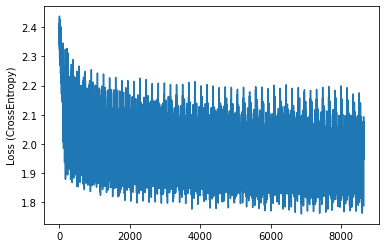

In [ ]:
#load image datasets
train_data = CMPDataset(BASE_DATASET_PATH)
test_data = CMPDataset(EXTENDED_DATASET_PATH)

#load saved model
model = SegFormer(512, model_name = None) #set model_name to an already fine-tuned model to start from there

#set hyper-parameters
OPTIMIZER_NAME = "adam" #"adam" or "sgd"
LR = 0.00006
EPOCHS = 50

if OPTIMIZER_NAME == "adam":
  optimizer = torch.optim.Adam(model.head.parameters(), lr = LR)
elif OPTIMIZER_NAME == "sgd":
  optimizer = torch.optim.SGD(model.head.parameters(), lr = LR, momentum = 0.9)

if USE_WANDB: wandb.init(
    # set the wandb project where this run will be logged
    project = "ssiw_transfer_learning_cmp",
    
    # track hyperparameters and run metadata
    config = {
      "embeddings": DEFINITIONS_TYPE,
      "dataset": "base",
      "optimizer": OPTIMIZER_NAME,
      "learning_rate": LR,
      "learning_rate_scheduler": "constant_lr",
      "epochs": EPOCHS
    }
)

#fine tune the model
fine_tune(model, train_data, optimizer, text_embs, epochs = EPOCHS)

#save new checkpoint
MODEL_NAME = 'ssiw_fine_tuned_{}_{}_{}'.format(DEFINITIONS_TYPE, OPTIMIZER_NAME, EPOCHS)

save_path = os.path.join(ROOT_PATH, MODELS_DIR , MODEL_NAME + '.pt')
torch.save({'head_state_dict': model.head.state_dict()}, save_path)

In [ ]:
#evaluate model performance
zero_shot_model = SegFormer(512)

zero_shot_miou = evaluate_performance(zero_shot_model, test_data, labels, text_embs)
fine_tuned_miou = evaluate_performance(model, test_data, labels, text_embs)

if USE_WANDB: 
  wandb.log({"zero-shot mIoU": zero_shot_miou})
  wandb.log({"fine-tuned mIoU": fine_tuned_miou})

print("\nZero-shot mIoU:", zero_shot_miou)
print("Fine-tuned mIoU:", fine_tuned_miou)

100%|██████████| 113/113 [01:36<00:00,  1.17it/s]


Zero-shot mIoU: 0.13495909868473374
Fine-tuned mIoU: 0.241632248041045


In [ ]:
#finish the wandb run, necessary in notebooks
if USE_WANDB: wandb.finish()

fine-tuned mIoU,▁
loss,█▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
zero-shot mIoU,▁
fine-tuned mIoU,0.24163
loss,1.95038
zero-shot mIoU,0.13496


In [ ]:
#save prediction images. helpful to visually analyze the results
zero_shot_predictions_path = os.path.join(ROOT_PATH, PREDICTIONS_DIR, "zero_shot")

if os.path.exists(zero_shot_predictions_path) == False: #there is no need to run zero-shot prediction if they are already available
  save_predictions(zero_shot_model, test_data, text_embs, "zero_shot")
  
save_predictions(model, test_data, text_embs, MODEL_NAME)

# Results

Please check this **[link](https://api.wandb.ai/report/hussein-fawzy/lwkks95u)** for the report on the results

# Future Work

In order to improve the performance and usability of the model, the following points should be taken into consideration:
*   Fine-tune the model on two steps;one, disable encoder training and only train the head (already done) on the new dataset, and two, enable encoder training and train the whole network on the new dataset with a lower learning rate
*   Use a validation set when fine-tuning the model
*   Try fine-tuning with a learning-rate decay model (ex. step or exponential)
*   Annotate output (predicted) images with labels